<div style="border:solid Chocolate 2px; padding: 40px">

#  Прогнозирование заказов такси на следующий час

</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Улучшение-результатов-с-помощью-Prophet" data-toc-modified-id="Улучшение-результатов-с-помощью-Prophet-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Улучшение результатов с помощью Prophet</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

### Описание задачи

В нашем распоряжении исторические данные о заказах такси в аэропортах. Нужно спрогнозировать количество заказов такси на следующий час. 

Задача: построить модель для такого предсказания.

Для оценки качества моделей следует применить метрику RMSE (значение на тестовой выборке должно быть не больше 48).

### План работы

Исследование пройдет в пять этапов:

1. Обзор данных.
2. Исследовательский анализ данных.
3. Подготовка признаков.
4. Обучение моделей.
5. Улучшение результатов с помощью библиотеки Prophet.
6. Выбор лучшей модели и проверка на тестовых данных.

## Подготовка

In [1]:
#pip install prophet

In [2]:
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import os
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
pth = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth):
    df = pd.read_csv(pth, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков в датасете нет. Проверим, отсортированы ли даты и время по порядку.

In [6]:
df.index.is_monotonic_increasing

True

Выполним ресемплирование по одному часу.

In [7]:
df = df.resample('1H').sum()
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


### Выводы

В нашем распоряжении датасет высокого качества, временной ряд расположен по порядку, пропуски в данных отсутствуют. Можем использовать данные для дальнейшего анализа.

## Анализ

Посмотрим на тренды и сезонность временного ряда в данных.

In [8]:
decomposed = seasonal_decompose(df)

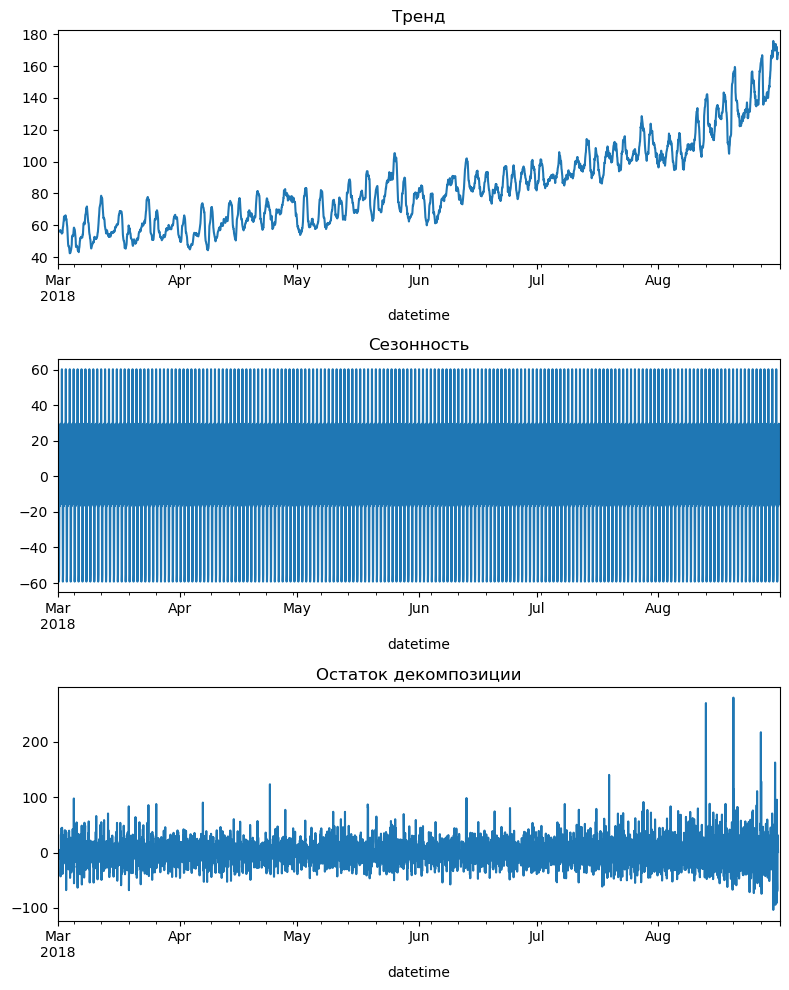

In [9]:
plt.figure(figsize=(8,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')

plt.tight_layout()

Наблюдается явный тренд - количество заказов растет. Связано ли это с тем, что число заказов такси возрастает в летний сезон по сравнению с весной, или с тем, что сервис в целом активно развивается и демонстрирует постоянный рост числа заказов - неизвестно. Чтобы делать выводы, необходимо посмотреть на более продолжительный промежуток - как минимум за год.

Проанализируем остаток. К концу графика "остатков" заметно больше, а значит, в тестовую выборку попадёт больше данных с выбросами и модели будет сложнее предсказывать. Таким образом, можем ожидать значительную разницу между результатами метрик на валидационной и на тестовой выборках, и это не обязательно будет означать переобучение модели.

Что касается сезонности, её нужно посмотреть на более коротком промежутке: в течение 2 дней.

Text(0.5, 1.0, 'Сезонность за 2 дня')

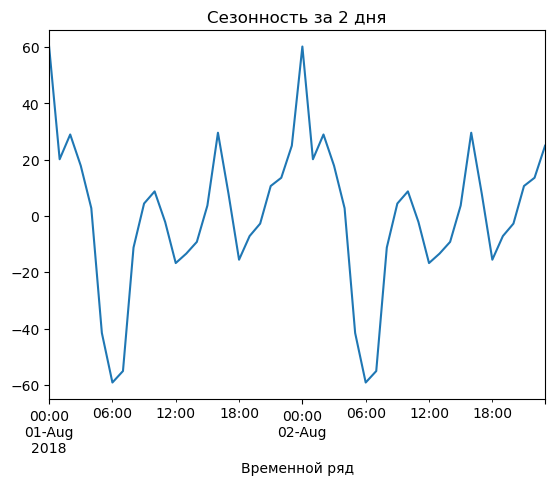

In [10]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot()
plt.xlabel('Временной ряд')
plt.title('Сезонность за 2 дня')

Видим, что пик заказов приходится на ночное время (00:00), и затем число заказов падает до минимума к 6 утра. Еще два явных пика по количеству заказов: в районе 11 часов и 16-17 часов.

Посмотрим также на недельную сезонность.

Text(0.5, 1.0, 'Сезонность за месяц')

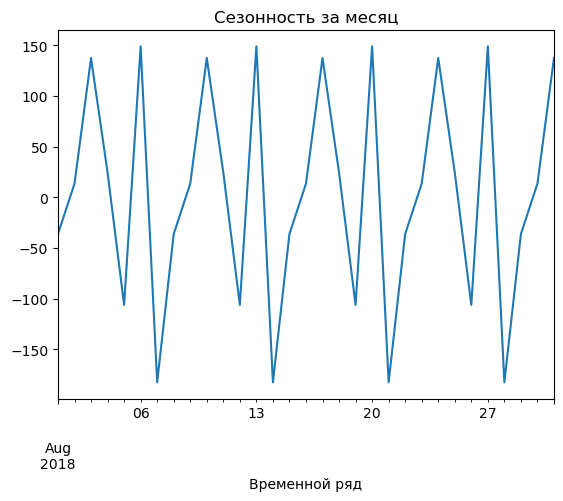

In [11]:
day_resample = df.resample('1D').sum()
day_decomposed = seasonal_decompose(day_resample)
day_decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.xlabel('Временной ряд')
plt.title('Сезонность за месяц')

Видим, что в данных присутствует ярко выраженная недельная сезонность. Значит, при добавлении новых признаков есть смысл добавить признак "день недели".

## Обучение

### Подготовка признаков

Создадим признаки:
1. Календарные: день, день недели и час;
2. Отстающие значения;
3. Скользящее среднее.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(df, 25, 4)
df.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


Выделим тестовую выборку (10%) и разделим на признаки и целевой признак.

In [14]:
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis = 1), df.num_orders, 
                                                    shuffle=False, test_size=0.1)

print(X_train.index.min(), X_train.index.max())
print(y_train.index.min(), y_train.index.max())
print(X_test.index.min(), X_test.index.max())
print(y_test.index.min(), y_test.index.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [15]:
del df

### Обучение моделей

Поскольку целевой признак - количественный, перед нами стоит задача регрессии. Применим следующие модели: линейная регрессия, случайный лес и CatBoost. Будем использовать инструменты кросс-валидации, поэтому нам понадобится TimeSeriesSplit.

In [16]:
cv = TimeSeriesSplit(n_splits=5)

Начнем с модели Линейной регрессии.

In [17]:
results = {}

In [18]:
linear_model = LinearRegression() 
linear_model.fit(X_train, y_train)
mse = cross_val_score(linear_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv).mean()
rmse = round((-mse) **0.5, 2)
results['LinearRegression'] = rmse
rmse

27.43

Теперь подберем гиперпараметры для Случайного леса и обучим модель.

In [19]:
%%time
forest_model = RandomForestRegressor()

forest_params = {
    'max_depth': range(2,10,1),
    'n_estimators': range(50,300,10),
    'min_samples_leaf': range(1,20,1),
    'min_samples_split': [2,3,4,5]
}

forest_cv = RandomizedSearchCV(forest_model, forest_params, cv=cv, random_state=321, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
forest_cv.fit(X_train, y_train)
rmse = round((-forest_cv.best_score_) **0.5, 2)
results['RandomForestRegressor'] = rmse
rmse

CPU times: user 9.63 s, sys: 157 ms, total: 9.79 s
Wall time: 1min 5s


26.14

In [20]:
randomforest_model = forest_cv.best_estimator_

Подберем гиперпараметры для CatBoost и обучим модель.

In [21]:
%%time
catboost_model = CatBoostRegressor(verbose = 100)

catboost_params = {'iterations': [50, 100, 150], 
          'depth': range(2,5,1),
          'learning_rate': [0.1, 0.3, 0.4] }

catboost_cv = RandomizedSearchCV(catboost_model, catboost_params,
                                 scoring='neg_mean_squared_error', 
                                 cv=cv, n_iter=15, n_jobs=-1, random_state=321)

catboost_cv.fit(X_train, y_train)
rmse = round((-catboost_cv.best_score_) **0.5, 2)
results['CatBoostRegressor'] = rmse
rmse

0:	learn: 33.7960310	total: 56.1ms	remaining: 8.36s
100:	learn: 17.7494518	total: 230ms	remaining: 112ms
149:	learn: 16.0195910	total: 339ms	remaining: 0us
CPU times: user 1.05 s, sys: 112 ms, total: 1.16 s
Wall time: 8.36 s


25.47

In [22]:
catboost_model = catboost_cv.best_estimator_

Сравним результаты, которые показали разные модели.

In [23]:
results = pd.Series(results)
results

LinearRegression         27.43
RandomForestRegressor    26.14
CatBoostRegressor        25.47
dtype: float64

Лучший результат показала модель CatBoostRegressor. Посмотрим, можно ли еще улучшить этот результат, если добавить признаки, используя библиотеку Prophet.

### Улучшение результатов с помощью Prophet

Для обучения Prohet создадим новый датасет.

In [24]:
if os.path.exists(pth):
    df_prophet = pd.read_csv(pth)
elif os.path.exists(pth2):
    df_prophet = pd.read_csv(pth2)
else:
    print('Something is wrong')

df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [25]:
df_prophet['datetime'] = pd.to_datetime(df_prophet['datetime'])
df_prophet = df_prophet.set_index('datetime')
df_prophet = df_prophet.resample('1H').sum()
df_prophet = df_prophet.reset_index()
df_prophet.head()

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


In [26]:
df_prophet = df_prophet.rename(columns={'datetime': 'ds', 'num_orders': 'y'})

In [27]:
#удалим первые строки, которые мы удалили в датасете df после добавления лагов
df_prophet = df_prophet.iloc[25:, :]
df_prophet.head()

,ds,y
25,2018-03-02 01:00:00,120
26,2018-03-02 02:00:00,75
27,2018-03-02 03:00:00,64
28,2018-03-02 04:00:00,20
29,2018-03-02 05:00:00,11


In [28]:
#разделим выборку на трейновую и тестовую, аналогичные уже созданным X_train, y_train, X_test, y_test
train_prophet, test_prophet = train_test_split(df_prophet, shuffle=False, test_size=0.1)

#проверим, чтобы даты совпадали с датами в первоначальных трейновой и тестовой выборках
print(train_prophet.ds.min(), train_prophet.ds.max())
print(test_prophet.ds.min(), test_prophet.ds.max())

2018-03-02 01:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [29]:
#обучим модель на трейновой выборке
prophet_model = Prophet()
prophet_model.fit(train_prophet)

21:15:07 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
#проверим размер тестовой выборки, чтобы осуществить make_future_dataframe на аналогичное количество строк
test_prophet.shape

(440, 2)

In [31]:
future = prophet_model.make_future_dataframe(periods=440, freq='H')

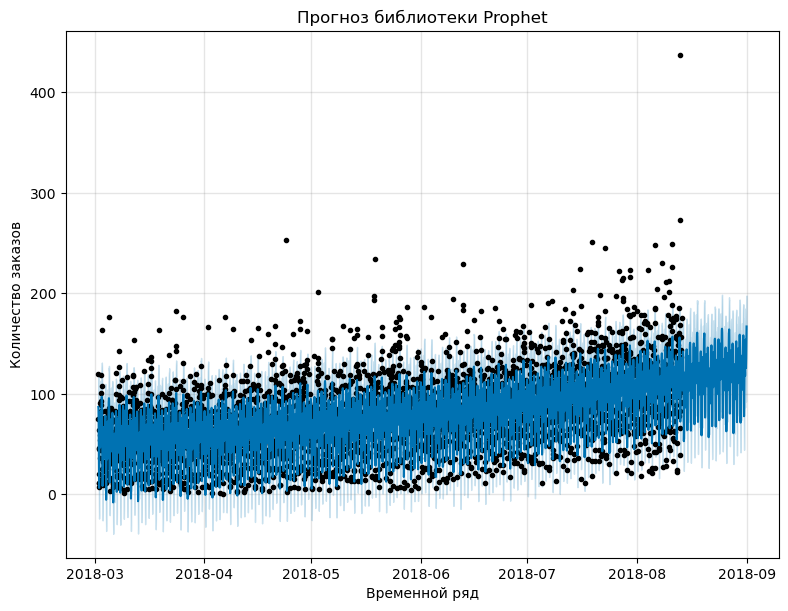

In [32]:
forecast = prophet_model.predict(future)
prophet_model.plot(forecast, figsize=(8,6))
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.title('Прогноз библиотеки Prophet')
plt.show()

In [33]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-02 01:00:00,54.049471,56.206300,120.039315,54.049471,54.049471,32.891349,32.891349,32.891349,32.688609,32.688609,32.688609,0.202739,0.202739,0.202739,0.0,0.0,0.0,86.940820
1,2018-03-02 02:00:00,54.056703,55.483862,114.566915,54.056703,54.056703,30.389672,30.389672,30.389672,29.394169,29.394169,29.394169,0.995503,0.995503,0.995503,0.0,0.0,0.0,84.446375
2,2018-03-02 03:00:00,54.063936,39.580747,104.809354,54.063936,54.063936,17.720048,17.720048,17.720048,15.893204,15.893204,15.893204,1.826845,1.826845,1.826845,0.0,0.0,0.0,71.783984
3,2018-03-02 04:00:00,54.071168,12.848049,80.742972,54.071168,54.071168,-6.728785,-6.728785,-6.728785,-9.415765,-9.415765,-9.415765,2.686979,2.686979,2.686979,0.0,0.0,0.0,47.342382
4,2018-03-02 05:00:00,54.078400,-10.346406,53.068847,54.078400,54.078400,-33.758859,-33.758859,-33.758859,-37.324457,-37.324457,-37.324457,3.565598,3.565598,3.565598,0.0,0.0,0.0,20.319541


У нас появилось много дополнительных признаков, которые могут быть потенциально полезны для обучения модели. Можем передать эти признаки, объединив с уже имеющимися трейновыми и тестовыми признаками.

In [34]:
#объединим новые признаки с обучающей выборкой
X_train_merged = X_train.merge(forecast, left_index=True, right_on='ds')
X_train_merged.shape

(3951, 48)

In [35]:
#объединим новые признаки с тестовой выборкой
X_test_merged = X_test.merge(forecast, left_index=True, right_on='ds')
X_test_merged.shape

(440, 48)

In [36]:
%%time
#проверим на кросс-валидации значение RMSE для модели CatBoost с доп.обучающими признаками
rmse = round((-cross_val_score(catboost_model, X_train_merged, y_train, 
                                   scoring='neg_mean_squared_error', cv=cv).mean()) **0.5, 2)
rmse

0:	learn: 25.4797997	total: 2.62ms	remaining: 390ms
100:	learn: 7.1869929	total: 243ms	remaining: 118ms
149:	learn: 4.9624818	total: 332ms	remaining: 0us
0:	learn: 26.5379699	total: 2.63ms	remaining: 392ms
100:	learn: 10.4345653	total: 237ms	remaining: 115ms
149:	learn: 8.4030167	total: 320ms	remaining: 0us
0:	learn: 27.5905965	total: 2.21ms	remaining: 329ms
100:	learn: 12.4765788	total: 197ms	remaining: 95.8ms
149:	learn: 10.5286411	total: 289ms	remaining: 0us
0:	learn: 28.7750047	total: 2.5ms	remaining: 373ms
100:	learn: 13.6006035	total: 234ms	remaining: 114ms
149:	learn: 11.9084750	total: 335ms	remaining: 0us
0:	learn: 30.0091700	total: 2.5ms	remaining: 372ms
100:	learn: 14.9654220	total: 233ms	remaining: 113ms
149:	learn: 13.3485455	total: 339ms	remaining: 0us
CPU times: user 4.52 s, sys: 294 ms, total: 4.82 s
Wall time: 1.82 s


23.87

Значение RMSE улучшилось. 

## Тестирование

Протестируем модель CatBoost, обученную на обычных признаках и с добавлением признаков с помощью Prophet, и посмотрим на результаты RMSE.

In [37]:
rmse =  mean_squared_error(catboost_model.predict(X_test), y_test, squared=False)
rmse

43.542616841714754

In [38]:
catboost_model.fit(X_train_merged, y_train)
rmse =  mean_squared_error(catboost_model.predict(X_test_merged), y_test, squared=False)
rmse

0:	learn: 33.3329651	total: 2.66ms	remaining: 396ms
100:	learn: 16.5210483	total: 262ms	remaining: 127ms
149:	learn: 14.8936909	total: 379ms	remaining: 0us


40.00823586327941

Лучший результат - у CatBoostRegressor, обученной с добавлением признаков с помощью библиотеки Prophet.

Посмотрим на результаты предсказаний vs фактические значения на графике.

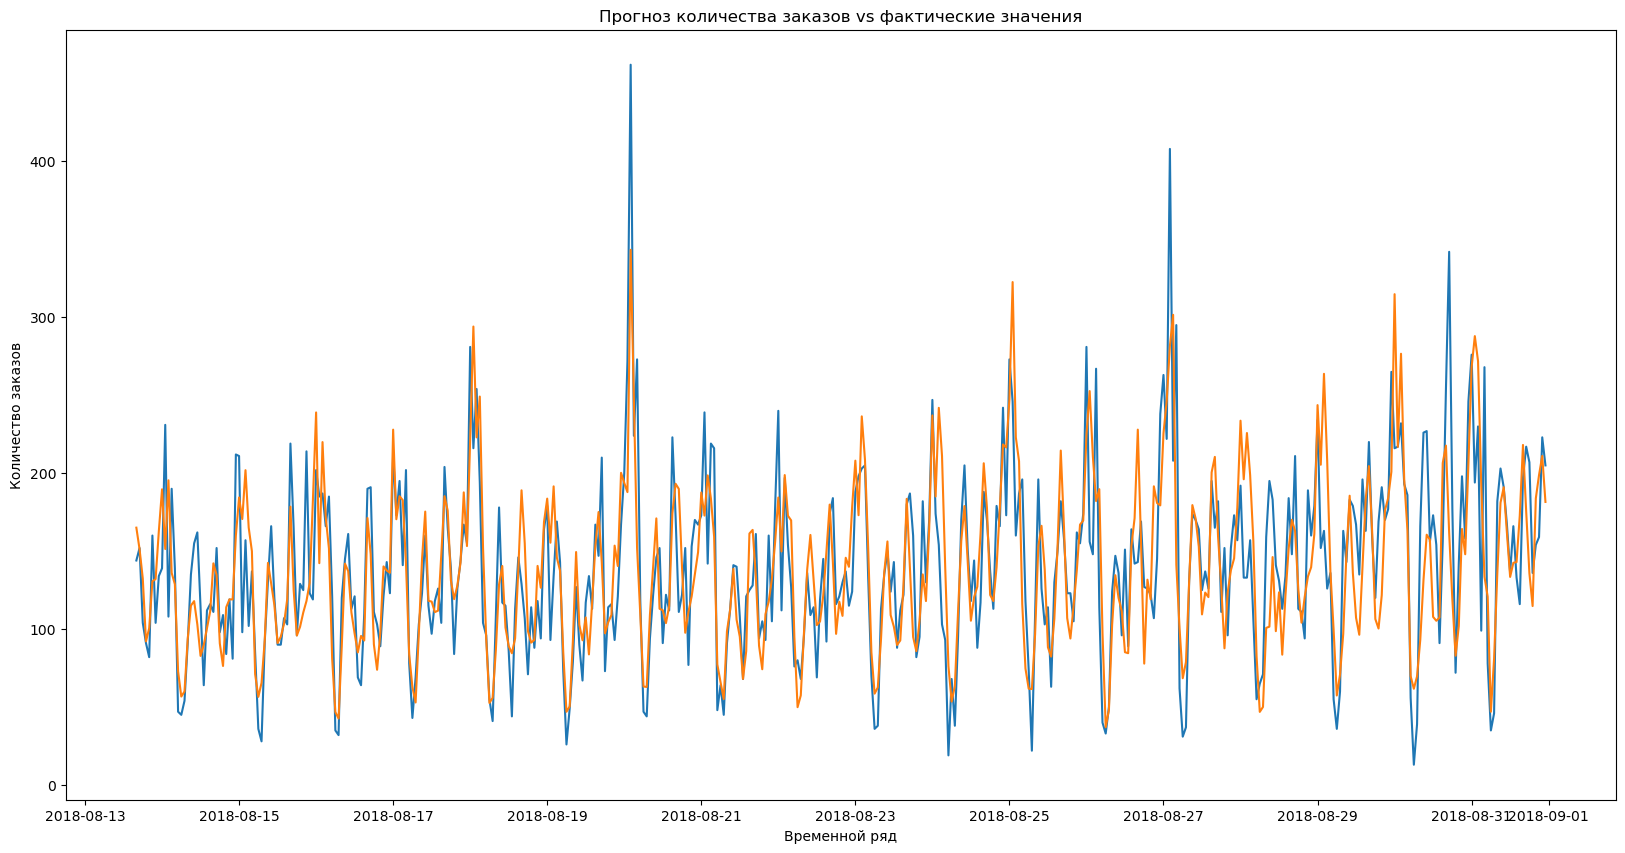

In [39]:
plt.figure(figsize=(20,10))
plt.plot(X_test.index, y_test)
plt.plot(X_test.index, catboost_model.predict(X_test_merged))
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.title('Прогноз количества заказов vs фактические значения')
plt.show()

Оценим модель на адекватность - посмотрим на предсказания, используя предыдущее значение ряда.

In [40]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
rmse = mean_squared_error(pred_previous, y_test) ** 0.5
rmse

58.881776776551476

Значение RMSE у константной модели получилось значительно больше, чем у нашей обученной модели. Таким образом, можем сделать вывод, что модель адекватна.

## Выводы

Перед нами стояла задача: создать прототип модели для предсказания количества заказов такси на следующий час. RMSE модели не выше 48.

В рамках исследования мы предобработали и проанализировали исторические данные о заказах такси в аэропортах, и далее проверили несколько моделей: Линейная регрессия, Случайный лес и CatBoost, применив различные гиперпараметры. Также мы воспользовались библиотекой Prophet, чтобы создать дополнительные признаки для обучения лучшей модели.

В результате нам удалось выбрать наиболее эффективную модель - CatBoostRegressor, применение которой даёт наилучший показатель RMSE на тестовой выборке: 40.3.